# Linear Regression Solution

In this exercise, we apply a linear regression to learn the dynamics of a system. 

<hr style="clear:both">

This exercise is part of a series of exercises for the ME-390-EPFL Foundations of Artificial Intelligence course at EPFL. Copyright (c) 2022 [Sycamore](https://www.epfl.ch/labs/sycamore/) lab at EPFL.
Use of this source code is governed by an MIT-style license that can be found in the LICENSE file or at https://www.opensource.org/licenses/MIT

**Author(s):** Tony Wood, Andreas Schlaginhaufen, Loris di Natale

This exercise is composed of 4 parts: 
- Part 1: Data loading & pre-processing
- Part 2: Linear regression
- Part 3: Regularization
- Part 4: Analysis and conclusions


## Task description

You are asked to learn the model of a controlled ground robot from measurement data. The state of the robot is represented by its pose, $\mathbf{x}(t) := \begin{bmatrix}p_0(t),p_1(t),\varphi(t)\end{bmatrix}^\top \in \mathbb{R}^3$, where $p_0$ and $p_1$ are position coordinates and $\varphi$ is the orientation of the robot. The model of the robot is given by the following ordinary differential equation, 

$$ \dot{\mathbf{x}}(t) = \begin{bmatrix} \dot{p}_0(t) \\ \dot{p}_1(t) \\ \dot{\varphi}(t) \end{bmatrix} = f(\mathbf{x}(t)) = \begin{bmatrix} 
f_{p_0}(\mathbf{x}(t)) \\
f_{p_1}(\mathbf{x}(t)) \\
f_{\varphi}(\mathbf{x}(t)) 
\end{bmatrix}, $$ 

for some unknown $f:\mathbb{R}^3\to\mathbb{R}^3$ that you want to identify. You can assume that each component of $f$ can be represented by a linear feature model $f_i(\mathbf{x}; {\mathbf{w}}_i)=\mathbf{w}_i^\top\mathbf{\Phi}(\mathbf{x})$ for $i=1,2,3$, where $\mathbf{w}_i^\top$ denotes the transpose of the vector $\mathbf{w}_i$. Moreover, $\mathbf{\Phi}(\mathbf{x})=\begin{bmatrix}1, p_0,p_1,\varphi, \cos(\varphi), \sin(\varphi)\end{bmatrix}^\top\in\mathbb{R}^{6}$ is the feature vector and $\mathbf{w}_i\in\mathbb{R}^{6}$ for $i=1,2,3$ are the parameters for each component.  

Your task is to use linear regression to learn the optimal model parameters $\mathbf{w}^*_i$ for $i=1,2,3$.

## Part 0: Imports

### 0.1 Imports and helpers for plotting
Before starting the exercise, we need to generate the data to train our models

Run this code to import packages and customize the settings of matplotlib to create beautiful plots.

In [1]:
import matplotlib
import numpy as np
import pandas as pd
from typing import Tuple

#this next line is only needed in iPython notebooks
%matplotlib inline 
import math
import matplotlib.font_manager as fm
font = fm.FontProperties(size = 12)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

### 0.2 Import helper functions

To help you throughout this homework, we prepared a few helper functions. You can find them in `functions.py`.  
Feel free to browse this file - you shouln't need to edit anything.



In [2]:
from functions import _fix_seed, generate_trajectories, plot_trajectories, generate_X_Y, separate_trajectories, plot_data, predict_and_plot

## Part 1: Data generation

Let us define the state of the robot as $\mathbf{x} := \begin{bmatrix}p_0,p_1,\varphi\end{bmatrix}^\top$, where $p_0$ and $p_1$ are position coordinates and $\varphi$ is the orientation of the robot.

The true behaviour of the differential wheeled robot are given by the following equations, 
$$ \dot{\mathbf{x}} = \begin{bmatrix} \dot{p}_0 \\ \dot{p}_1 \\ \dot{\varphi} \end{bmatrix} = f(\mathbf{x}) = \begin{bmatrix} 
f_{p_0}(\mathbf{x}) \\
f_{p_1}(\mathbf{x}) \\
f_{\varphi}(\mathbf{x}) 
\end{bmatrix} = \begin{bmatrix} v \cdot \cos(\varphi) \\ v \cdot \sin(\varphi) \\ \omega \end{bmatrix}$$
where the speed, $ v$, and the turn rate, $\omega$, are kept constant. The training data will consist of noisy state measurements sampled along different trajectories of the system.

Note: A trajectory of the robot refers to the sequence of states $p_0(t), p_1(t), \varphi(t)$ generated from a given initial condition $p_0(0), p_1(0), \varphi(0)$ over a time interval $t \in [0, T]$. 

The following simulation data is generated with parameter values, 
$$ v = 0.5 \textrm{m/s}, $$
$$ \omega = - \pi / 3.$$

**Question:** What would the trajectories look like in the 2 dimensional space, $p_0$, $p_1$? 

**Answer:** They would be a circle.

### 1.1 Simulating the System: train and test data

Using the equations above and the helper functions `generate_trajectories` and `plot_trajectories`, you can generate a train and a test dataset as follows.  

Note that we use `_fix_seed` to fix a random seed. This ensures reproducibility, i.e. all random operations can be repeated. 

#### Train data
We generate trajectories of the robot from different initial conditions. The state variables are measured with some noise. Hence, we have noisy measurements of $p_0(t), p_1(t), \varphi(t)$ starting from a random initial condition $p_0(0), p_1(0), \varphi(0)$, over a time interval $t \in [0,T]$

In [3]:
#####
_fix_seed(7) # DO NOT CHANGE FOR SUBMISSIONS _fix_seed(7)
#####

number_trajectories_train = 10
noise = 0.001


# Generate the train data 
# This returns a set of trajectories (it is in the pandas dataframe format and can be converted to numpy)
dfs_train = generate_trajectories(number_trajectories_train, noise)

print(f'\nNumber of dataframes:\t{len(dfs_train)}')
print(f'Shape of one dataframe:\t{dfs_train[0].shape}\n')

display(dfs_train[1].head())


Number of dataframes:	10
Shape of one dataframe:	(2500, 4)



,t,p_0,p_1,phi
0,0.00,-0.157089,0.340074,-1.435616
1,0.02,-0.160404,0.331301,-1.446044
2,0.04,-0.156794,0.318155,-1.468128
3,0.06,-0.152876,0.307034,-1.492291
4,0.08,-0.151971,0.301004,-1.513196


#### Test data

We generate the trajectories of the robot the same way as we generated the training set but from a different initial condition and different noise sequence. 

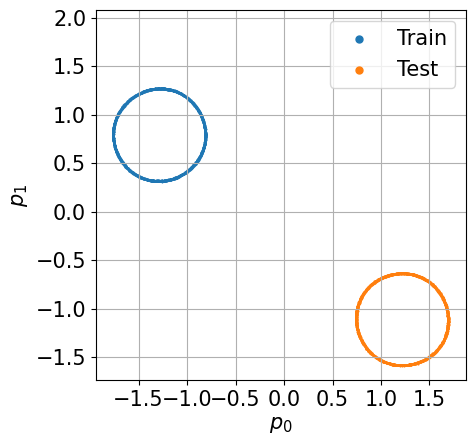

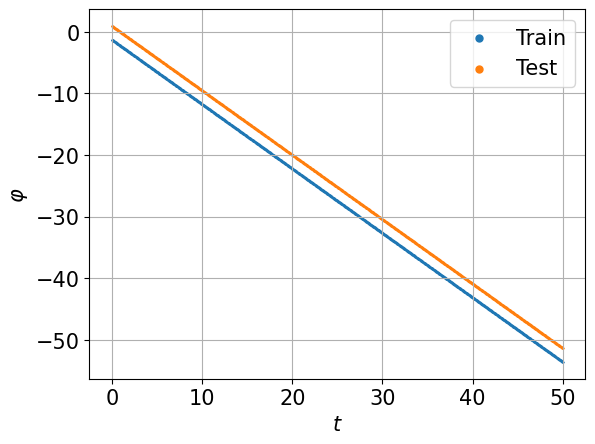

In [4]:
#####
_fix_seed(13434252) #DO NOT CHANGE FOR SUBMISSIONS _fix_seed(13434252)
#####

number_trajectories_test = 10
noise = 0.001

# Generate test data
dfs_test = generate_trajectories(number_trajectories_test, noise)

# Plot the last train and test trajectory - just one trajectory for each
plot_trajectories([dfs_train[-1], dfs_test[-1]], labels=['Train', 'Test'])

### 1.2 Generate the targets

As you can see, each trajectory contains information about the time step and state, i.e. $\lbrace(t^i, \mathbf{x}^i)\rbrace_{i=1}^N$ with $ \mathbf{x}^i:= \mathbf{x}(t^i)$ sampled at an equal rate $\Delta t=t_{i+1} - t_{i}$.  

However, recall that we want to approximate $f$, i.e. the derivative $\dot{x}$, which we don't have in the data. Hence, you first need to generate the targets $\mathbf{y}^i := f(\mathbf{x}^i) = \dot{\mathbf{x}}(t^i) $.  
Since the true $\dot{\mathbf{x}}(t^i)$ is unknown, you can approximate it via the finite difference:
$$\dot{\mathbf{x}}(t^i)\approx \dfrac{\mathbf{x}(t^{i+1})-\mathbf{x}(t^{i})}{t^{i+1}-t^i}.$$

Your first exercise is to complete the function below to generate these targets (you can drop the last data point of each trajectory for simplicity, because you don't know $x^{N+1}$).

In [6]:
def generate_target(df: pd.DataFrame) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Generate targets via finite differences.
    
    Args:
        df (pd.DataFrame): Dataframe containing trajectory data
        
    Returns:
        X (np.ndarray): State measurements, Array of shape (trajectory_length-1, 3)
        Y (np.ndarray): Finite differences, Array of shape (trajectory_length-1, 3)
        t (np.ndarray): Time vector, Array of shape (trajectory_length-1,)
    """
    # here, we convert the dataframe to numpy format
    X = df[['p_0', 'p_1', 'phi']].to_numpy()
    t = df['t'].to_numpy()
    Y = np.zeros((len(t)-1, 3))
    
    
    ### START CODE HERE ### (≈ 3 lines of code)
    # Hint: review numpy indexing array
    # X = ...
    # Y = ...
    # t = ...
    ### END CODE HERE ###
    
    # Solution:
    X_plus = X[1:, :]
    X = X[:-1, :]
    t = t[:-1]
    Y = (X_plus - X)/(t[1]-t[0])
    
    return X, Y, t

You can now use the provided `generate_X_Y` function to generate the X and Y that we will use later, both for the training and test data.  Note that this function merges the 10 training trajectories in a single dataframe. It does the same for the test trajectories. For visualization, later on, we separate the test trajectories into 10 sets. 

In [7]:
# Generate the data and have a look at the evaluation data we created
df_train, df_test = generate_X_Y(dfs_train, dfs_test, generate_target)

# We now have the time, the 3 states (X), and the derivatives (Y) together
print('\nShape of the test data:', df_test.shape, '\n')
df_test.head()


Shape of the test data: (24990, 7) 



,t,p0,p1,phi,dp0dt,dp1dt,dphidt
0,0.00,0.409088,0.247644,-2.147937,-0.396237,-0.184503,-1.312568
1,0.02,0.401163,0.243954,-2.174189,-0.062646,-0.367758,-1.159755
2,0.04,0.399910,0.236599,-2.197384,-0.584855,-0.689634,-0.772276
3,0.06,0.388213,0.222806,-2.212829,-0.253693,-0.369329,-0.733869
4,0.08,0.383139,0.215420,-2.227507,-0.236194,-0.419237,-1.498952


As expected, this added the needed (approximate) derivatives to the data. This allows us to define X and Y below.  
Note that we use a helper function to separate the trajectories of the test set to provide nicer plots in the rest of the notebook.

In [8]:
# Use the entire data for training
X_train = df_train[['p0', 'p1', 'phi']].to_numpy()
Y_train = df_train[['dp0dt', 'dp1dt', 'dphidt']].to_numpy()
X_test = df_test[['p0', 'p1', 'phi']].to_numpy()
Y_test = df_test[['dp0dt', 'dp1dt', 'dphidt']].to_numpy()

# For plotting, we only consider one trajectory at a time
# This function separates the test data into separate trajectories
t_test_trajs, X_test_trajs, Y_test_trajs = separate_trajectories(df_test, number_trajectories_test)

print(f'We have {len(X_test_trajs)} test trajectories')

We have 10 test trajectories


### 1.3 Data Preview
We can now check what X and Y look like, for example on the fifth test trajectory.

[0.000e+00 2.000e-02 4.000e-02 ... 4.992e+01 4.994e+01 4.996e+01]


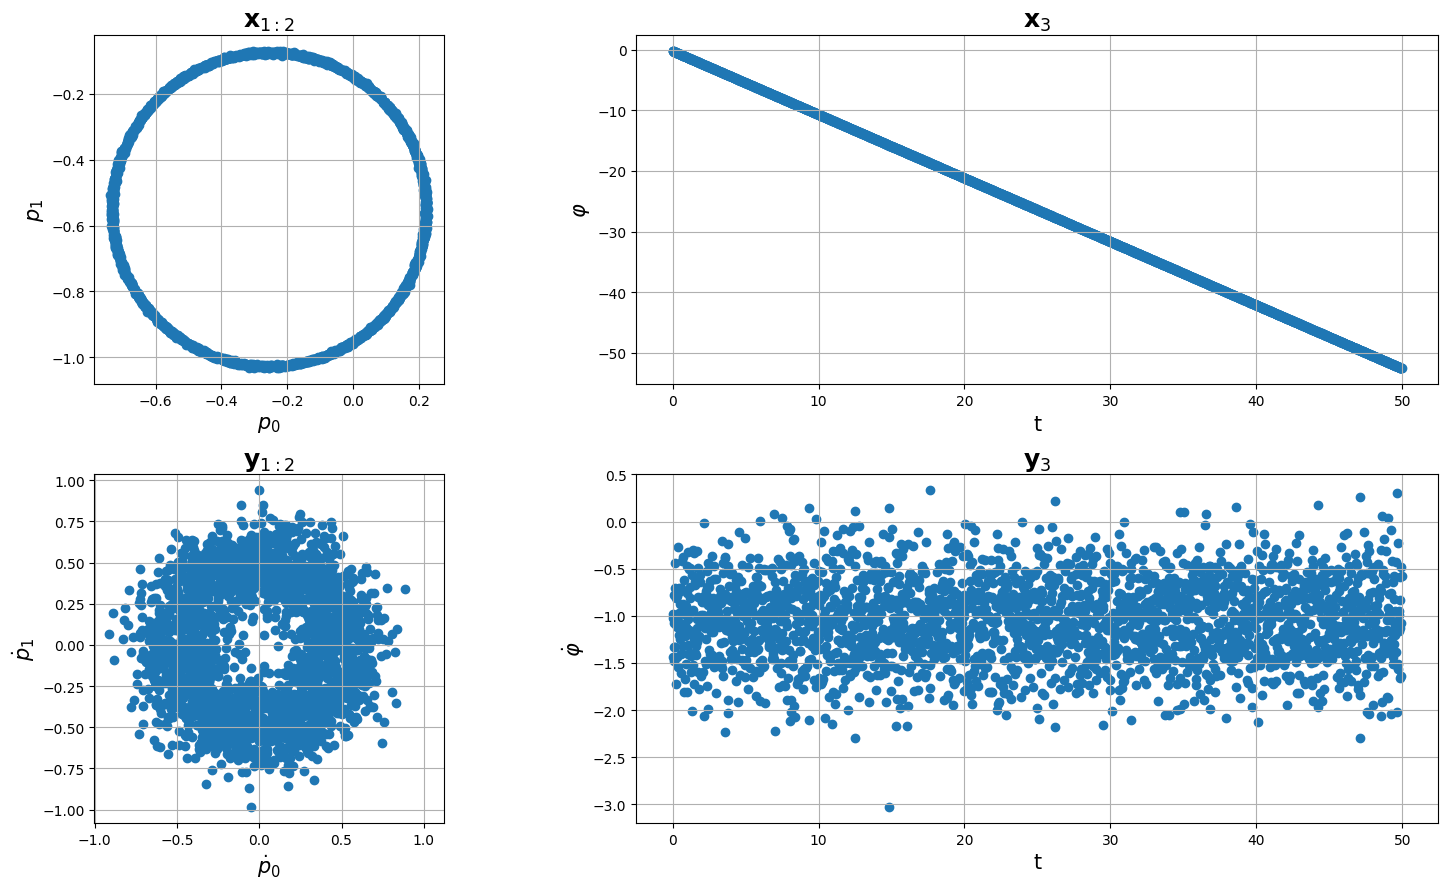

In [10]:
trajectory = 2

plot_data(t_test_trajs[trajectory], X_test_trajs[trajectory], Y_test_trajs[trajectory])

## Part 2: Linear Regression: preliminaries

In this part, you are required to learn the model parameters via linear regression.

### 2.1 Pre-compute the features 
First, you need to implement the feature map:
$$\mathbf{X}:=\begin{bmatrix} {\mathbf{x}^1}^\top \\ \vdots \\ {\mathbf{x}^N}^\top \end{bmatrix} \mapsto \mathbf{\Phi}(\mathbf{X}):=\begin{bmatrix} \mathbf{\Phi}(\mathbf{x}^1)^\top \\ \vdots \\ \mathbf{\Phi}(\mathbf{x}^N)^\top \end{bmatrix}.$$
Recall, $\mathbf{x}^\top$ denotes the transpose of the vector $\mathbf{x}$, $\mathbf{X}\in \mathbb{R}^{N\times 3}$ is the input data matrix, and $\mathbf{\Phi}(\mathbf{x})=\begin{bmatrix}1,p_0,p_1,\varphi, \cos(\varphi), \sin(\varphi)\end{bmatrix}^\top\in\mathbb{R}^{6}$.

In [11]:
# Complete the code below (element-wise numpy operations may be useful):
def feature_map(X: np.ndarray) -> np.ndarray:
    """ 
    Generates feature map from input data matrix.
    
    Args: 
        X (np.ndarray): Input data matrix, shape (N,3)
        
    Returns:
        Phi(X) (np.ndarray): Feature matrix, shape (N,6)
    """
    
    
    ### START CODE HERE ### (≈ 3 lines of code)
    # ...
    # feature_matrix = ...
    ### END CODE HERE ###
    
    # solution:
    p_0 = X[:,0]
    p_1 = X[:,1]
    phi = X[:,2]
    cos_phi = np.cos(phi)
    sin_phi = np.sin(phi)
    
    return np.stack([np.ones_like(p_0), p_0, p_1, phi, cos_phi, sin_phi], axis=1)

nfeatures = feature_map(X_train).shape[1]

print(f'\nOriginal shape of X: {X_train.shape}')
print(f'Shape after the feature map has been applied: {feature_map(X_train).shape}\n')


Original shape of X: (24990, 3)
Shape after the feature map has been applied: (24990, 6)



### 2.2 Define the linear model

Now that the feature map is defined, you can use it to define your linear model $f_i(\mathbf{x}; {\mathbf{w}}_i)=\mathbf{w}_i^\top\mathbf{\Phi}(\mathbf{x})$ for $i=1,2,3$.  
Note that the model is the same for each component, only the parameter $w_i$ differs, so you only need to define one $f$ below.


**Question:** Expand the term: $\mathbf{w}_1^\top\mathbf{\Phi}(\mathbf{x})$ into its 6 components. You may use $\mathbf{w}_{1,j}$ to refer to $j$-th element of $\mathbf{w}_1$.

**Answer:** $\mathbf{w}_1^\top\mathbf{\Phi}(\mathbf{x}) = \mathbf{w}_{1,0}1 + \mathbf{w}_{1,1}p_0 + \mathbf{w}_{1,2}p_1 + \mathbf{w}_{1,3} \varphi + \mathbf{w}_{1,4} \cos(\varphi) + \mathbf{w}_{1,5} \sin(\varphi)$

In [12]:
# define model and parameters (including bias)
w_1 = np.zeros(nfeatures)
w_2 = np.zeros(nfeatures)
w_3 = np.zeros(nfeatures)

# implement the linear model
def f(X: np.ndarray, w: np.ndarray) -> np.ndarray:
    """
    Linear regression model.
    
    Args:
        X (np.ndarray): Input data matrix, shape (N,3)
        w (np.ndarray): Weight vector, shape (6,)
        
    Returns:
        f(X, w) (np.ndarray): Predicted targets, shape (N,)
    """
    
    ### START CODE HERE ### (≈ 1 lines of code)
    # ...
    ### END CODE HERE ###

    # solution:
    return feature_map(X) @ w

print(f(X_train, w_1).shape)

(24990,)


You will learn one vector of weigths for each dimension, we hence separate the targets.

In [13]:
# Split target into the three components to predict separately
y_1_train = Y_train[:,0]
y_2_train = Y_train[:,1]
y_3_train = Y_train[:,2]

y_1_test = Y_test[:,0]
y_2_test = Y_test[:,1]
y_3_test = Y_test[:,2]

### 2.3 Mean Square Error
You are now asked to implement a method to compute the Mean Squared Error (MSE) $J$, which is defined as:
$$
\begin{align}
J(\mathbf{w}_i) = \frac{1}{N} (\mathbf{\Phi}(\mathbf{X}) \mathbf{w}_i-\mathbf{y})^{T} (\mathbf{\Phi}(\mathbf{X}) \mathbf{w}_i-\mathbf{y}).
\end{align}$$
Above $\mathbf{\Phi}(\mathbf{X}) \in \mathbb{R}^{N \times 6}$

In [14]:
def mse_loss(X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
    """Computes the Mean Square Error (MSE)
    
    Args:
        X (np.ndarray): Dataset of shape (N, 3)
        y (np.ndarray): Labels of shape (N, )
        w (np.ndarray): Weights of shape (6, )

    Returns:
        float: the MSE loss
    """
    ### START CODE HERE ### (≈ 3 lines of code)
    # ...
    ### END CODE HERE ###
    
    # Solution
    N = y.shape[0]
    y_hat = f(X, w)
    loss = (1/ N) * ((y_hat - y).T @ (y_hat - y))
    
    return loss

# Test it on the first training dimension with the weight initialized as 0:
print(f'Loss on dimension 1 with w1=0: {mse_loss(X_train, y_1_train, w_1): .3f}')

Loss on dimension 1 with w1=0:  0.143


### 2.4: Least squares method
Estimate the optimal parameters $\mathbf{w}_i^*$ via the least squares method seen in the exercises.

In [15]:
def least_squares(X: np.ndarray, y: np.ndarray) -> np.ndarray:
    """Solves linear regression using least squares

    Args:
        X: Data of shape (N, 3)
        y: Labels of shape (N, )

    Returns:
        Weight parameters of shape (6, )
    """

    ### START CODE HERE ### (≈ 1 line of code)
    # ...
    ### END CODE HERE ###
    
    # Solution
    w = np.linalg.solve(feature_map(X).T @ feature_map(X), feature_map(X).T @ y)
    
    return w

Use your function to train w1, w2, and w3. You can then use the provided `predict_and_plot` function to check your implementations.

Train error on dimension 1:  0.02002
Test error dimension 1:  0.01996
Train error on dimension 2:  0.01985
Test error dimension 2:  0.02011
Train error on dimension 3 :  0.19751
Test error dimension 3:  0.19587
Test prediction:


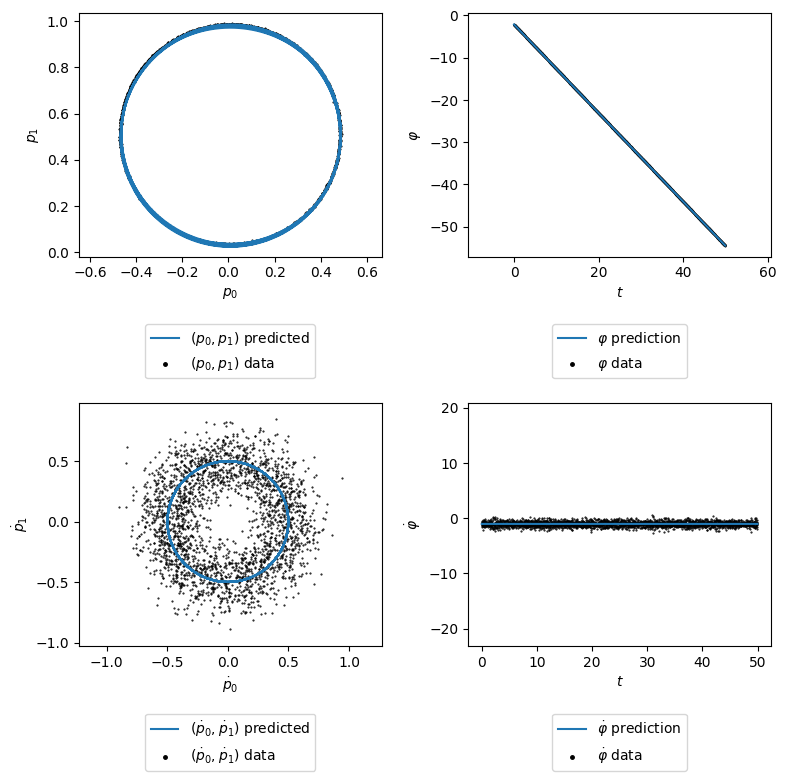

In [16]:
w_1 = least_squares(X_train, y_1_train)
w_2 = least_squares(X_train, y_2_train)
w_3 = least_squares(X_train, y_3_train)

# print the train error for each dimension
print(f'Train error on dimension 1: {mse_loss(X_train, y_1_train, w_1): .5f}')
print(f'Test error dimension 1: {mse_loss(X_test, y_1_test, w_1): .5f}')
print(f'Train error on dimension 2: {mse_loss(X_train, y_2_train, w_2): .5f}')
print(f'Test error dimension 2: {mse_loss(X_test, y_2_test, w_2): .5f}')
print(f'Train error on dimension 3 : {mse_loss(X_train, y_3_train, w_3): .5f}')
print(f'Test error dimension 3: {mse_loss(X_test, y_3_test, w_3): .5f}')

# Plot the prediction along the first test trajectory as an example
print('Test prediction:')
for i in range(1):
    predict_and_plot(X_test_trajs[i], Y_test_trajs[i], t_test_trajs[i], w_1, w_2, w_3, feature_map)

**Question:** Is the model overfitting, underfitting or performing well? 

**Answer:**  
We can make the following two observations:
- Firstly, our linear model fits the data well, as evident in the plots above and below. Since it can recover the true trajectories accurately, we know the model is not underfitting.
- On the other hand, we can also observe that the training and testing errors are roughly equivalent. This indicates that our model is not overfitting the training data and still generalizes well enough. 

We can hence conclude that the model is performing well, it neither over- nor underfits the data.

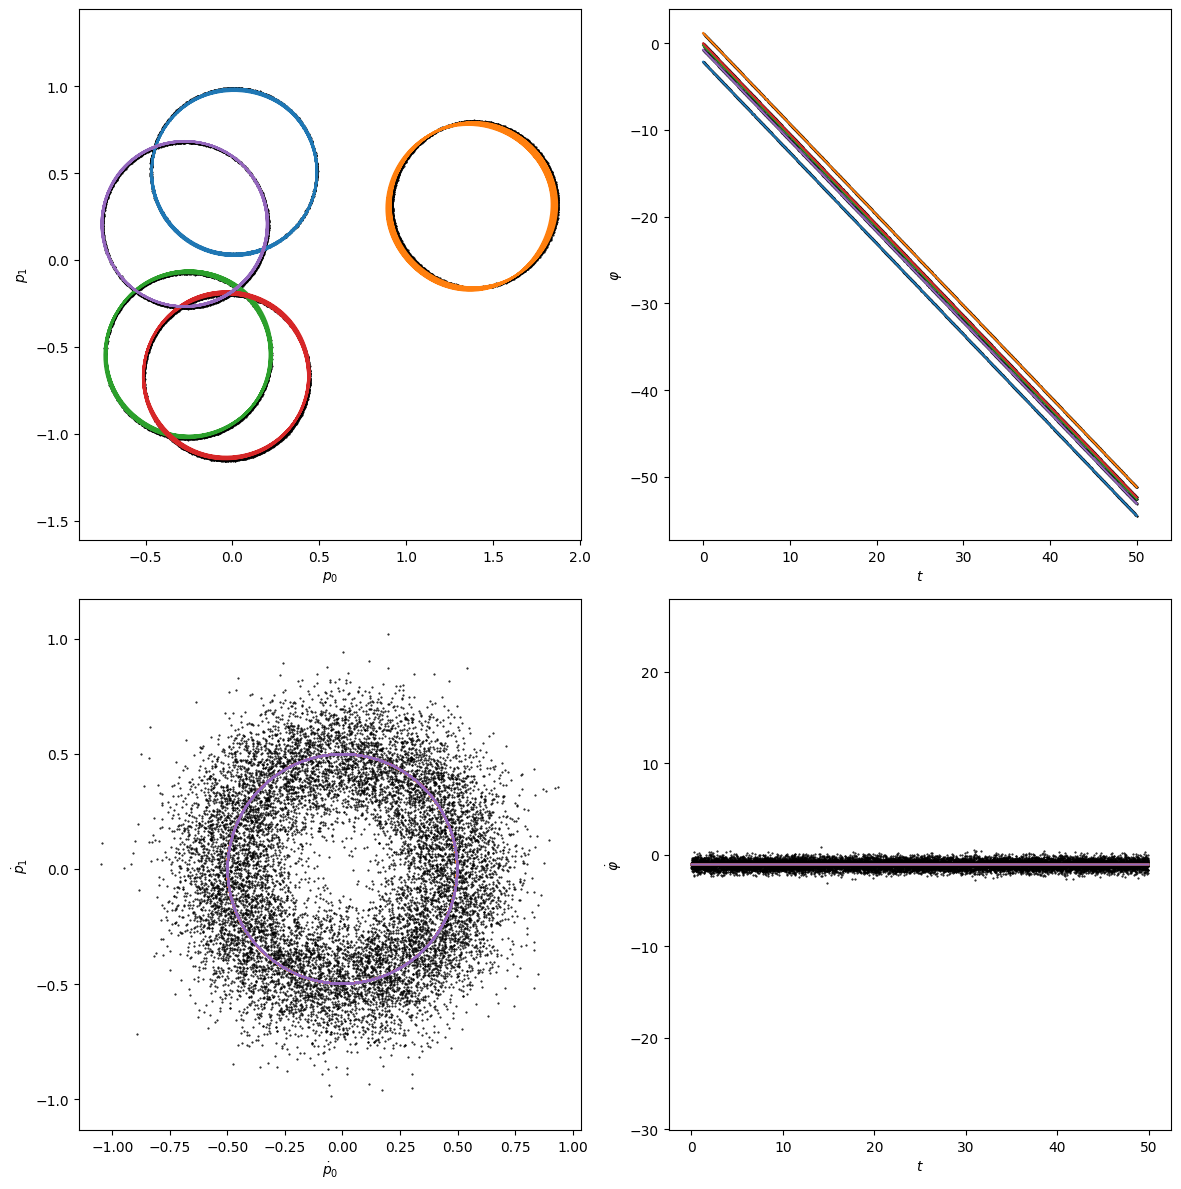

In [17]:
# You can also plot several trajectories together, but it becomes hard to see the difference
predict_and_plot(X_test_trajs[:5], Y_test_trajs[:5], t_test_trajs[:5], w_1, w_2, w_3, feature_map)

## Part 3: Ridge regression

Similarly to the classical least square regression above, you are now tasked to implement the Ridge regression

**Question:** Explain the motivation for regularization in a supervised learning problem. How would you expect the regularization influence the generalization for this specific problem? 

**Answer**:  
In supervised learning problems, regularization helps to avoid overfitting.  
The main idea is to force the learned model to be as simple as possible - simpler explanations are indeed better in general. When one implements regularization, the hope is hence to increase the generalization capability of the model, not letting it specialize too much to the training data.  

In our case, since the model is performing well - in particular, it is not overfitting -, we don't expect a lot of improvement with the use of regularization. On the contrary, if we try to regularize it too much, we expect the model performance to decrease: if we force the model to be too simple (i.e. the weights to be very small in the case of Ridge regression), it might not be able to fit the data well anymore!

__Note__: Generally, regularization does **not** help avoid underfitting!  
Indeed, if your model is underfitting the data, it means it is not able to capture the true behavior of the system. Since regularization would add additional constraints on the model, forcing it to be even simpler, it can only worsen its performnce in general and lead to even more underfitting. In that case, the only solution is usually to use more complex models to fit the data better. In this exercise, we could for example add additional terms to the feature map to complexify the model and hope to capture the behavior of the robot better.  
This is however not needed since the fit is already good!

### 3.1 Ridge regularized MSE loss function

**Question:** For a component $i$, write the MSE loss function with ridge regularization

**Answer:**
$$
\begin{align}
J_i(\mathbf{w}_i) = \frac{1}{N} (\mathbf{\Phi}(\mathbf{X}) \mathbf{w}_i-\mathbf{y})^{T} (\mathbf{\Phi}(\mathbf{X}) \mathbf{w}_i-\mathbf{y}) + \lambda \begin{bmatrix}\mathbf{w}_{i,1}& \dots &\mathbf{w}_{i,5} \end{bmatrix}^\top\begin{bmatrix}\mathbf{w}_{i,1}\\ \vdots \\ \mathbf{w}_{i,5} \end{bmatrix}.
\end{align}$$

Implement the ridge regression in the code below. 

In [18]:
def ridge_regression(X: np.ndarray, y: np.ndarray, lambda_: float) -> np.ndarray:
    """Solves linear regression using least squares

    Args:
        X: Data of shape (N, 3)
        y: Labels of shape (N, )
        lambda_: regularization parameter

    Returns:
        Weight parameters of shape (6, )
    """

    ### START CODE HERE ### (≈ 4 line of code)
    # ...
    ### END CODE HERE ###
    
    # Solution
    N = len(y)
    V = np.eye(nfeatures)
    V[0,0] = 0
    w = np.linalg.solve(1/N * feature_map(X).T @ feature_map(X) + lambda_*V, 1/N * feature_map(X).T @ y)
    
    return w


And train for a set of ridge coefficients $\lambda$

Lambda:  0.0001
Train error on dimension 1:  0.02002
Test error dimension 1:  0.01996
Train error on dimension 2:  0.01985
Test error dimension 2:  0.02011
Train error on dimension 3 :  0.19751
Test error dimension 3:  0.19587
Prediction:


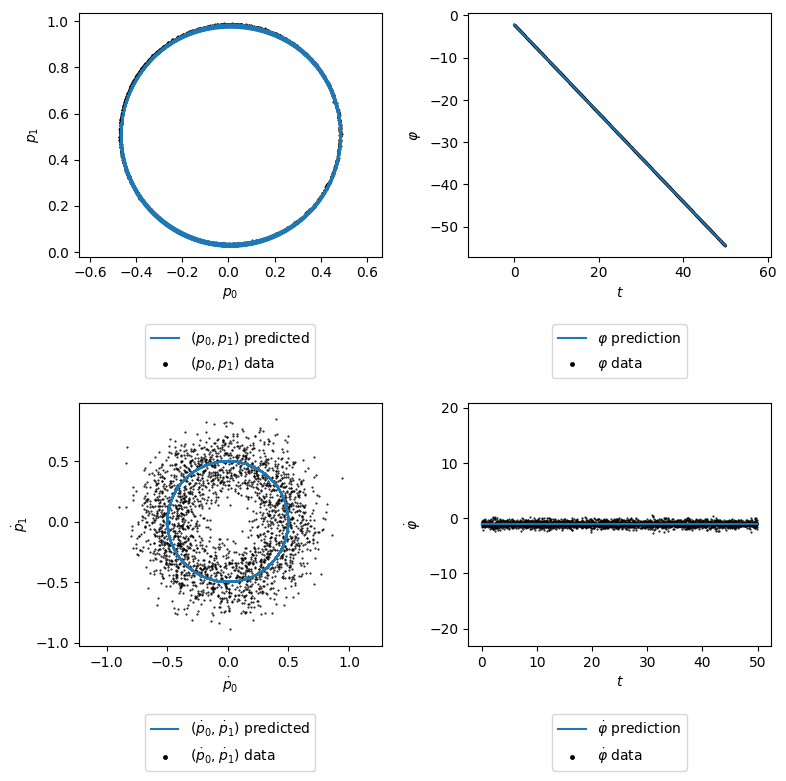

Lambda:  0.01
Train error on dimension 1:  0.02008
Test error dimension 1:  0.02004
Train error on dimension 2:  0.01991
Test error dimension 2:  0.02015
Train error on dimension 3 :  0.19751
Test error dimension 3:  0.19587
Prediction:


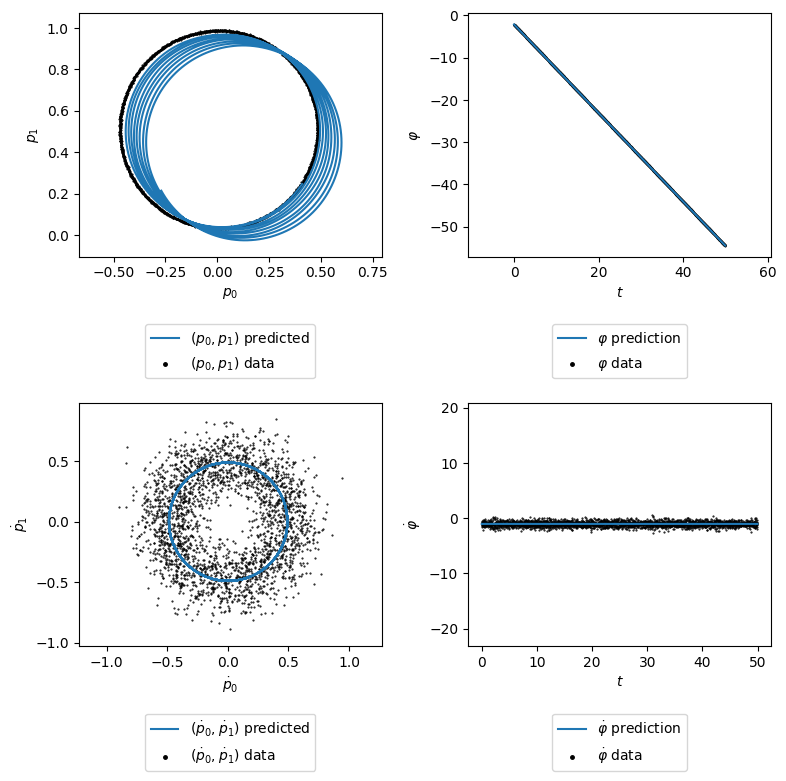

Lambda:  1.0
Train error on dimension 1:  0.07062
Test error dimension 1:  0.07281
Train error on dimension 2:  0.07146
Test error dimension 2:  0.07049
Train error on dimension 3 :  0.19751
Test error dimension 3:  0.19587
Prediction:


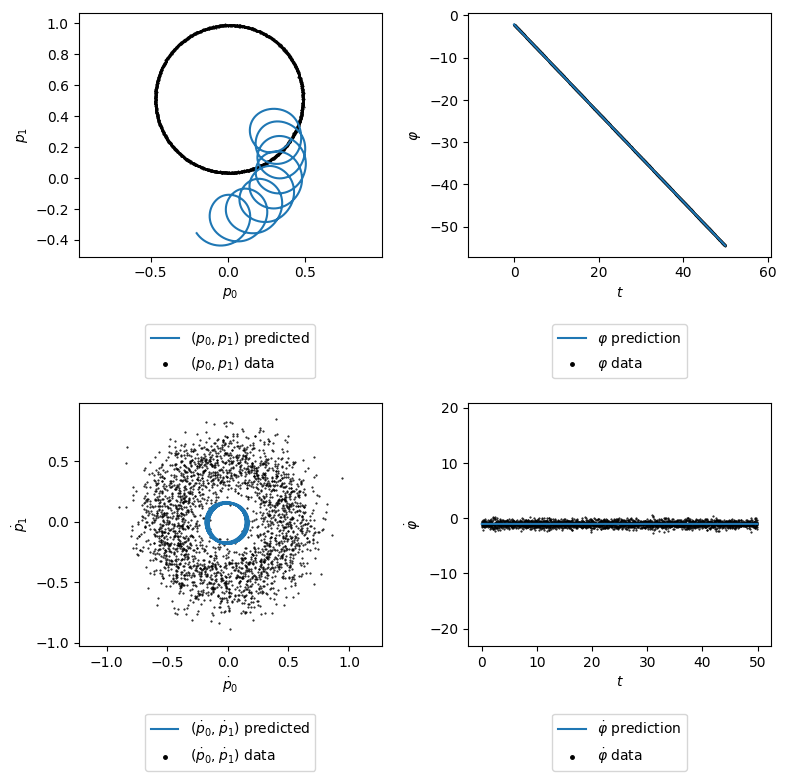

Lambda:  100.0
Train error on dimension 1:  0.14193
Test error dimension 1:  0.14383
Train error on dimension 2:  0.14362
Test error dimension 2:  0.14184
Train error on dimension 3 :  0.19751
Test error dimension 3:  0.19587
Prediction:


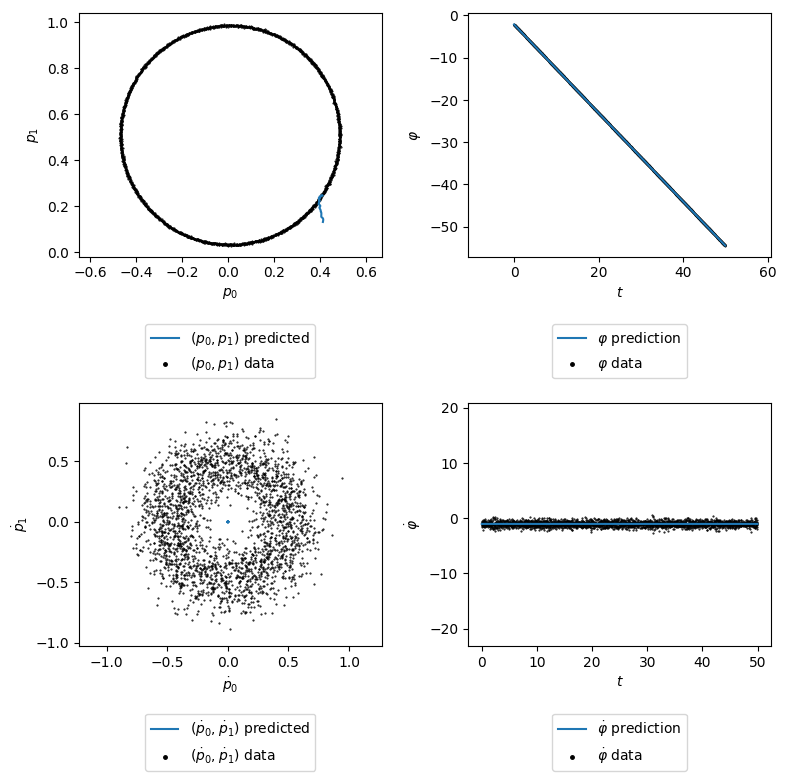

In [19]:
lambdas = [1e-4, 1e-2, 1.0, 1e2]
w_1_ridge = []
w_2_ridge = []
w_3_ridge = []
for i, lambda_ in enumerate(lambdas):
    print('Lambda: ', lambda_)
    
    w_1_ridge.append(ridge_regression(X_train, y_1_train, lambda_))
    w_2_ridge.append(ridge_regression(X_train, y_2_train, lambda_))
    w_3_ridge.append(ridge_regression(X_train, y_3_train, lambda_))

    # print the train error for each dimension
    print(f'Train error on dimension 1: {mse_loss(X_train, y_1_train, w_1_ridge[i]): .5f}')
    print(f'Test error dimension 1: {mse_loss(X_test, y_1_test, w_1_ridge[i]): .5f}')
    print(f'Train error on dimension 2: {mse_loss(X_train, y_2_train, w_2_ridge[i]): .5f}')
    print(f'Test error dimension 2: {mse_loss(X_test, y_2_test, w_2_ridge[i]): .5f}')
    print(f'Train error on dimension 3 : {mse_loss(X_train, y_3_train, w_3_ridge[i]): .5f}')
    print(f'Test error dimension 3: {mse_loss(X_test, y_3_test, w_3_ridge[i]): .5f}')

    print('Prediction:')
    # Plot prediction along first trajectory
    for j in range(1):
        predict_and_plot(X_test_trajs[j], Y_test_trajs[j], t_test_trajs[j], w_1_ridge[i], w_2_ridge[i], w_3_ridge[i], feature_map)

### 3.2 Print learned weight vectors

Compare the learned weight vectors $\mathbf{w}_i$ for various values of $\lambda$.

In [20]:
### Weigt vectors

print('w_1:')
# w_1
print('lambda = 0.00: ', w_1)
for (i, lambda_) in enumerate(lambdas):
    print(f'lambda = {lambda_:.2e}: ',  w_1_ridge[i])

print('\nw_2:')
# w_2
print('lambda = 0.00: ', w_2)
for (i, lambda_) in enumerate(lambdas):
    print(f'lambda = {lambda_:.2e}: ',  w_2_ridge[i])

print('\nw_3:')
# w_1
print('lambda = 0.00: ', w_3)
for (i, lambda_) in enumerate(lambdas):
    print(f'lambda = {lambda_:.2e}: ',  w_3_ridge[i])

w_1:
lambda = 0.00:  [-3.37932793e-05 -4.34770505e-04 -2.19726194e-04 -2.22777847e-06
  4.98952805e-01  5.84608286e-03]
lambda = 1.00e-04:  [-4.93029989e-05 -4.09921057e-04 -1.48212114e-04 -2.42156091e-06
  4.98817712e-01  5.85557886e-03]
lambda = 1.00e-02:  [-1.49311943e-03  1.85603611e-03  6.52138224e-03 -2.04034397e-05
  4.85902721e-01  6.69590709e-03]
lambda = 1.00e+00:  [-1.19178796e-02  6.41126102e-03  5.45618685e-02 -1.53146102e-04
  1.56689149e-01  3.25606992e-03]
lambda = 1.00e+02:  [-1.65652030e-03  1.47060820e-05  1.16925819e-03 -5.42274579e-05
  2.45835143e-03  4.38033710e-05]

w_2:
lambda = 0.00:  [ 7.68266625e-05 -1.41759256e-04 -5.27362717e-04  8.36623170e-07
 -5.33248798e-03  4.98414213e-01]
lambda = 1.00e-04:  [ 8.47743655e-05 -1.94748953e-04 -5.48015680e-04  1.02556853e-06
 -5.32025750e-03  4.98291408e-01]
lambda = 1.00e-02:  [ 8.19925210e-04 -5.17445627e-03 -2.42378153e-03  1.87248483e-05
 -4.21736173e-03  4.86487257e-01]
lambda = 1.00e+00:  [ 0.00489962 -0.04941017 

### 3.3 Norm of parameters

Compare $||\mathbf{w}_i||_2$ for the different choices of the regularization parameter $\lambda$.

In [21]:
### Two norm of weights

print('norm of w_1:')
# w_1
print('lambda = 0.00: ', f'{math.sqrt(w_1.T @ w_1):.5f}')
for (i, lambda_) in enumerate(lambdas):
    print(f'lambda = {lambda_:.2e}: ',  f'{math.sqrt(w_1_ridge[i].T @ w_1_ridge[i]):.5f}')

print('\nnorm of w_2:')
# w_1
print('lambda = 0.00: ', f'{math.sqrt(w_2.T @ w_2):.5f}')
for (i, lambda_) in enumerate(lambdas):
    print(f'lambda = {lambda_:.2e}: ',  f'{math.sqrt(w_2_ridge[i].T @ w_2_ridge[i]):.5f}')
    
print('\nnorm of w_3:')
# w_1
print('lambda = 0.00: ', f'{math.sqrt(w_3.T @ w_3):.5f}')
for (i, lambda_) in enumerate(lambdas):
    print(f'lambda = {lambda_:.2e}: ',  f'{math.sqrt(w_3_ridge[i].T @ w_3_ridge[i]):.5f}')

norm of w_1:
lambda = 0.00:  0.49899
lambda = 1.00e-04:  0.49885
lambda = 1.00e-02:  0.48600
lambda = 1.00e+00:  0.16650
lambda = 1.00e+02:  0.00319

norm of w_2:
lambda = 0.00:  0.49844
lambda = 1.00e-04:  0.49832
lambda = 1.00e-02:  0.48654
lambda = 1.00e+00:  0.16710
lambda = 1.00e+02:  0.00275

norm of w_3:
lambda = 0.00:  1.04753
lambda = 1.00e-04:  1.04753
lambda = 1.00e-02:  1.04754
lambda = 1.00e+00:  1.04755
lambda = 1.00e+02:  1.04743


## Part 4: Analysis and remarks

Feel free to add a few cells below to illustrate you answers.

**Question**: What is the impact of $\lambda$ in the Ridge regresion?

**Solution**:  
From the results above, we can draw two main conclusions:
1. The larger $\lambda$, the lower the norm of the corresponding $w_1$ and $w_2$ (Section 3.3).
2. If $\lambda$ is chosen too large, it constrains the learning too much, leading to poor solutions (Section 3.1).

Both are expected in our case:
1. The additional penalty in Ridge regression is meant to reduce the norm of the model parameters. With a larger $\lambda$, the best way for the model to decrease the loss is to decrease the values of $w_1$, $w_2$. This leads to a simpler model with small coefficients.
2. Since our model was not overfitting in the first place, as mentioned in Section 2.4, regularization cannot help much. This is indeed confirmed by the results above, where we can see the loss (both for the training and testing data!) increase with larger $\lambda$s. Since we are trying to force the model to be simpler when it was already performing well, this leads to underfitting, and our linear regression is less and less able to capture the true behavior of the data with increasing $\lambda$s!

In general, $\lambda$ is a tuning paramter, and the best practice is to try different values and then select the best one.  
In this exercise, it seems that Least Squares performs very well, so we can set $\lambda=0$, or keep it very small.

__Note__: The third dimension behaves differently here:  
As can be seen in Section 3.2, only $w_{3,0}$ has a value significantly different from $0$, even for $\lambda=0$. This makes sense if you go back to the system equations presented in Part 1: the evolution of $\dot\varphi$ is a constant!  
Because we decided to discard $w_{3,0}$ from the regularization, this means the Ridge regression has essentially no impact on $w_3$ since all the regularized coefficients are already almost $0$! We can indeed check that neither the norm of $w_3$ nor the loss in dimension $3$ changes significantly for different $\lambda$s.

**Bonus Question**: What is the impact of the number of trajectories in the training data? Would a single trajectory suffice to identify the system for the given feature vector? Try to justify your answer experimentally and theoretically.

**Solution**: As plotted below, a single trajectory is not sufficient to fit the data well.  
In fact, this leads to clear overfitting for the classical Least Squares regression (first results and plot)! Indeed, we can see the testing loss skyrocket and be orders of magnitude larger than the training loss. If we look closely at what happens on the plotted test trajectories, we can for example see all the trajectories converging to the same circle in dimension $1$ and $2$ - the one the model was trained on - clearly illustrating overfitting. The model can only predict this training trajectory!

Since we now have a clear case of overfitting, we hope regularization can help - and you can see it indeed does!  
Increasing $\lambda$ not only decreases the norm of the learned parameters (and even in the third dimension), it now also decreases the testing loss significantly. Forcing the model to be simple helps us in the case. Even if it still overfits the training trajectory (compare the losses with the ones we obtained with 10 training trajectories), the model performs much better with regularization, clearly decreasing the testing loss. As can be seen from the plots, it converges to the training trajetory less aggressively, predicting changes of smaller magnitude ($\dot{p_0}$ and $\dot{p_1}$).

Once $\lambda$ is chosen too big, however, we again see the testing loss increase - the model starts to have troubles fitting the data and understanding the true trajectories are circles. At some point, for a very large regularization coefficient, the model predicts almost no movement of the robots, which is a very simple solution and fits the data fairly well - but is of course not what we expected!

As a conclusion, $\lambda~=0.01$ seems to be a wise choice if only one training trajectory is provided. Note that the fit is not too bad (the model fits the derivatives $\dot{p_0}$, $\dot{p_1}$, and $\dot\varphi$) even if the trajectories are a bit all over the place. This happens because we need to integrate the approximated derivatives to predict trajectories, which can amplify small errors.

__Note__: One can theoretically show that the problem is ill-posed if only a single trajectory is used to fit the linear model. Indeed, one can prove that multiple parameters $w$ could fit the data perfectly in that case, which then leads to poor generalization over new initial conditions.

In [ ]:
_fix_seed(23855)

# Generate train and test data
dfs_train = generate_trajectories(number_trajectories=1, noise=0.001)
dfs_test = generate_trajectories(number_trajectories=10, noise=0.001)

# Put it in the right form
df_train, df_test = generate_X_Y(dfs_train, dfs_test, generate_target)

X_train = df_train[['p0', 'p1', 'phi']].to_numpy()
Y_train = df_train[['dp0dt', 'dp1dt', 'dphidt']].to_numpy()
X_test = df_test[['p0', 'p1', 'phi']].to_numpy()
Y_test = df_test[['dp0dt', 'dp1dt', 'dphidt']].to_numpy()

# Separate the test data into separate trajectories for plots
t_train_trajs, X_train_trajs, Y_train_trajs = separate_trajectories(df_train, number_trajectories=1)
t_test_trajs, X_test_trajs, Y_test_trajs = separate_trajectories(df_test, number_trajectories=10)

# Split target into the three components to predict separately
y_1_train = Y_train[:,0]
y_2_train = Y_train[:,1]
y_3_train = Y_train[:,2]
y_1_test = Y_test[:,0]
y_2_test = Y_test[:,1]
y_3_test = Y_test[:,2]

# Least squares prediction
w_1 = least_squares(X_train, y_1_train)
w_2 = least_squares(X_train, y_2_train)
w_3 = least_squares(X_train, y_3_train)

# Plot the prediction along the first test trajectory as an example
print('\nLeast Squares\n')
print(f'Norms of the parameters:\nw_1: {np.linalg.norm(w_1)}\nw_2: {np.linalg.norm(w_2)}\nw_3: {np.linalg.norm(w_3)}\n')

# print the train error for each dimension
print(f'Train error on dimension 1: \t{mse_loss(X_train, y_1_train, w_1): .5f}')
print(f'Test error dimension 1: \t{mse_loss(X_test, y_1_test, w_1): .5f}')
print(f'Train error on dimension 2: \t{mse_loss(X_train, y_2_train, w_2): .5f}')
print(f'Test error dimension 2: \t{mse_loss(X_test, y_2_test, w_2): .5f}')
print(f'Train error on dimension 3 : \t{mse_loss(X_train, y_3_train, w_3): .5f}')
print(f'Test error dimension 3: \t{mse_loss(X_test, y_3_test, w_3): .5f}\n')
predict_and_plot(X_test_trajs, Y_test_trajs, t_test_trajs, w_1, w_2, w_3, feature_map)
    
lambdas = [1e-4, 1e-2, 1.0, 1e2]
for i, lambda_ in enumerate(lambdas):
    
    w_1_ridge = ridge_regression(X_train, y_1_train, lambda_)
    w_2_ridge = ridge_regression(X_train, y_2_train, lambda_)
    w_3_ridge = ridge_regression(X_train, y_3_train, lambda_)

    print('\nRidge regression with lambda: ', lambda_)
    print(f'\nNorms of the parameters:\nw_1: {np.linalg.norm(w_1_ridge)}\nw_2: {np.linalg.norm(w_2_ridge)}\nw_3: {np.linalg.norm(w_3_ridge)}\n')
    print(f'Train error on dimension 1: \t{mse_loss(X_train, y_1_train, w_1_ridge): .5f}')
    print(f'Test error dimension 1: \t{mse_loss(X_test, y_1_test, w_1_ridge): .5f}')
    print(f'Train error on dimension 2: \t{mse_loss(X_train, y_2_train, w_2_ridge): .5f}')
    print(f'Test error dimension 2: \t{mse_loss(X_test, y_2_test, w_2_ridge): .5f}')
    print(f'Train error on dimension 3 : \t{mse_loss(X_train, y_3_train, w_3_ridge): .5f}')
    print(f'Test error dimension 3: \t{mse_loss(X_test, y_3_test, w_3_ridge): .5f}\n')

    predict_and_plot(X_test_trajs, Y_test_trajs, t_test_trajs, w_1_ridge, w_2_ridge, w_3_ridge, feature_map)